# GEOG 5160 6160 Lab 10

# Introduction

This notebook will walk through setting up a model for the semantic segmentation of images using convolutional neural networks (CNNs). Unlike classification, where we attempt to predict a label associated with an image (e.g. cat or dog), in semantic segmentation, we are trying to label each pixel within an image. This is usually done by providing a corresponding mask for each training image that indicates which pixels belong to which class. The example used here is based on a set of aerial images taken across Dubai and used in a Kaggle competition:

https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

There are a total of 72 images and masks in this dataset. In the interest of making this tractable in a class, we'll just train the model using a subset (18) of these images, and only for a few epochs. With a relatively small dataset, the goal of this lab is demonstrate how to build and evaluate these models. I would not expect to get a very high level of accuracy without increasing both the size of the data and the number of epochs. 

The code to run UNet in this example has been modified from https://pub.aimind.so/satellite-imagery-segmentation-using-u-net-4ec7f265ddbe

## Objectives

- Build a simple segmentation model in TF/Keras
- Understand how to build an encoder and decoder branch in a convolutional neural network
- How to use skip-connections to preserve spatial structure


## Data processing

First, let's load some libraries

In [34]:
import os
import numpy as np
import random

from PIL import Image
import matplotlib.pyplot as plt

Next, we'll get the images. These are available through the class Google drive in the zip file *unet_images3.zip*. Download this now, and move it to a folder that is easy to find on your computer, and unzip it. This will create a set of folders that look like this:

```
- images3
    - images
    - masks
```

In each of these you'll find matching images. The `images` folder contains the RGB image as JPEGs, and the `masks` folder contains the matching mask as PNG files. The file names should match, so *image_part_001_000.png* will be the mask for *image_part_001_000.jpg*. These files are smaller tiles created from the original images. If you want to see what the original images look like, download and unzip the file *unet_images2.zip*. If you have this, you can load an example of each. Here's the first image:

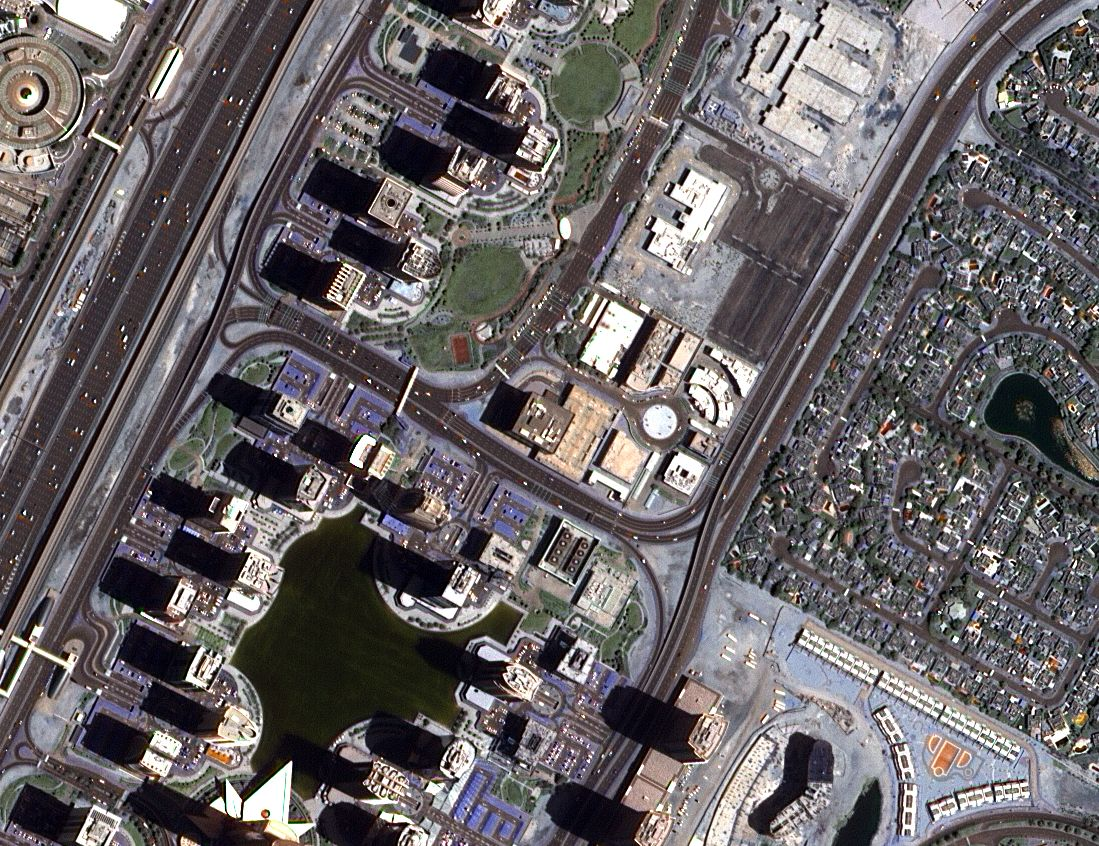

In [35]:
base_dir = './datafiles/images2/'
image_dir = base_dir + 'images/'
mask_dir = base_dir + 'masks/'
image_names = sorted(os.listdir(image_dir))

im = Image.open(image_dir + image_names[0])
display(im)

And the first mask

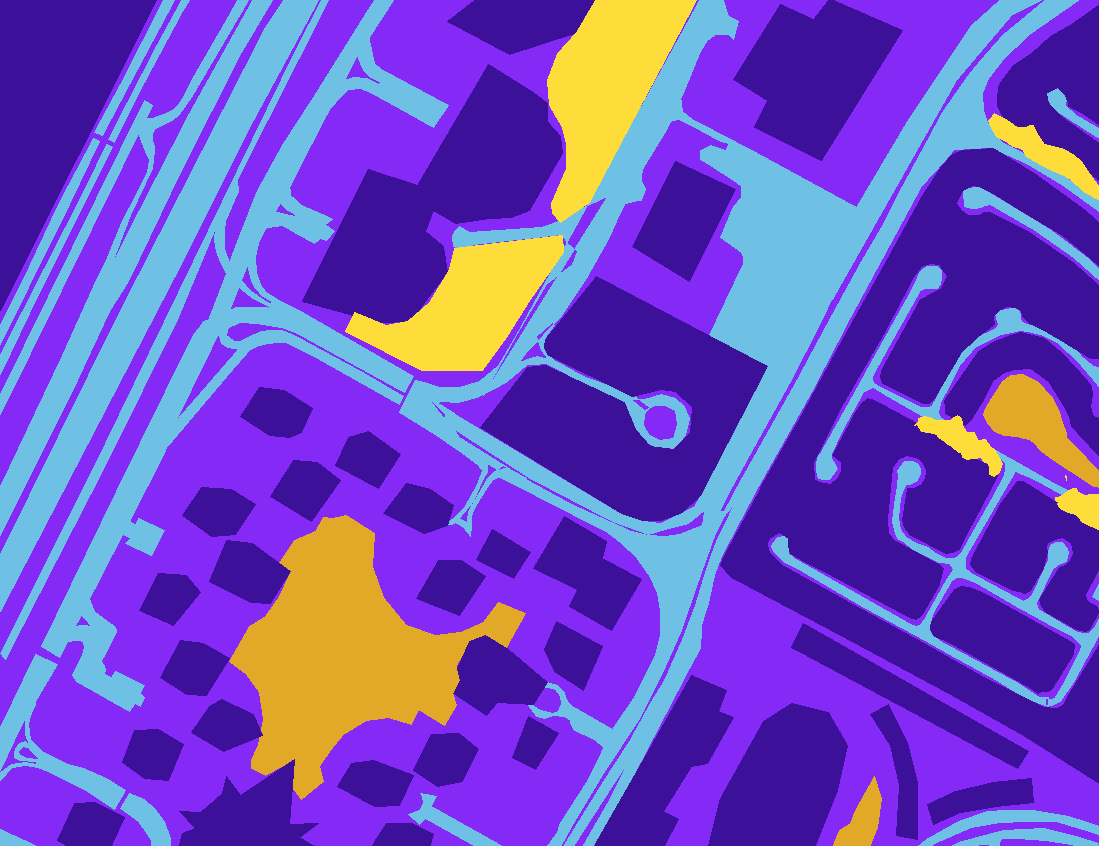

In [36]:
mask_names = [sub.replace('jpg', 'png') for sub in image_names]
mk = Image.open(mask_dir + mask_names[0])
display(mk)

Now let's take a look at the tiles. We'll make a list of the full paths to both images and masks for use in training the model

In [37]:
base_dir = "./datafiles/images3/"
input_dir = base_dir + "images/"
target_dir = base_dir + "masks/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [38]:
input_img_paths[0:10]

['./datafiles/images3/images/image_part_001_000.jpg',
 './datafiles/images3/images/image_part_001_001.jpg',
 './datafiles/images3/images/image_part_001_002.jpg',
 './datafiles/images3/images/image_part_001_003.jpg',
 './datafiles/images3/images/image_part_001_004.jpg',
 './datafiles/images3/images/image_part_001_005.jpg',
 './datafiles/images3/images/image_part_001_006.jpg',
 './datafiles/images3/images/image_part_001_007.jpg',
 './datafiles/images3/images/image_part_001_008.jpg',
 './datafiles/images3/images/image_part_001_009.jpg']

In [39]:
target_paths[0:10]

['./datafiles/images3/masks/image_part_001_000.png',
 './datafiles/images3/masks/image_part_001_001.png',
 './datafiles/images3/masks/image_part_001_002.png',
 './datafiles/images3/masks/image_part_001_003.png',
 './datafiles/images3/masks/image_part_001_004.png',
 './datafiles/images3/masks/image_part_001_005.png',
 './datafiles/images3/masks/image_part_001_006.png',
 './datafiles/images3/masks/image_part_001_007.png',
 './datafiles/images3/masks/image_part_001_008.png',
 './datafiles/images3/masks/image_part_001_009.png']

If we load the first image (we'll use Keras functions for this), you should see that it is the top-left corner of the original image

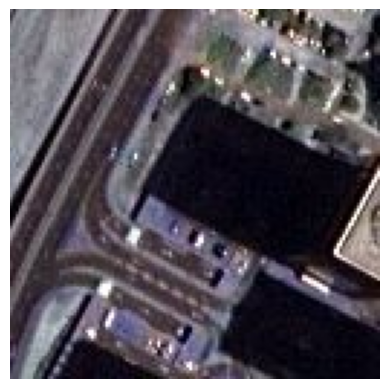

In [40]:
from keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[10]))

We'll load the matching mask as well. Note that this has been converted to an integer mask, with 6 possible classes:

```
Building = 0
Land = 1
Road = 2
Vegetation = 3
Water = 4
Unlabeled = 5
```

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_45549/3366736387.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', 3)


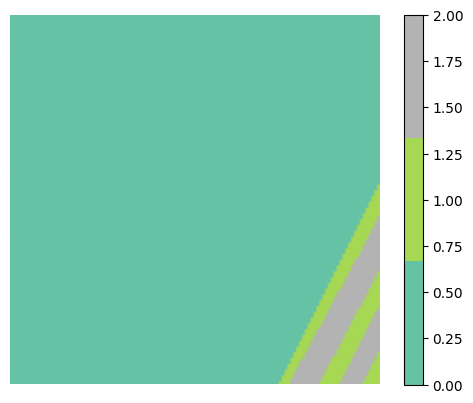

In [41]:
cmap = plt.cm.get_cmap('Set2', 3)

mask = img_to_array(load_img(target_paths[0], color_mode="grayscale"))
plt.axis("off")
plt.imshow(mask[:, :, 0], cmap=cmap)
plt.colorbar()


We'll now read in all the images. As this is a fairly small dataset, we'll simply read the images into memory. For larger sets, we would need to create a data generator here. First, we'll define the input image size - for this we'll keep the images at their original size (128x128) but this can be used if the tiles are of different sizes to ensure all input *tensors* are the same. We'll also randomly shuffle the images and mask, so that we can split these into training and validation sets (note that it is important to keep the seed (42) the same here so that it shuffles both masks and images in the same way)

In [42]:
img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_paths)

Next, we'll create a couple of functions to load the images and masks. For the images, this is pretty simple - we just use the Keras functions to load images and convert to numeric arrays. For the masks, we need to specify these as gray scale, as there is only one channel, and then convert to an integer (`unit8`),

In [43]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") # - 1
    return img

Now, we'll use these functions to loop over the list of files, read them and store them in **numpy** arrays. 

In [44]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

And as a last step, we'll create a training and validation set by moving the final 500 images in the list to a validation set

In [45]:
num_val_samples = 500
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

As a quick sanity check, here are the first ten images and masks. If the file names do not match, then check your code!

In [46]:
input_img_paths[0:10]

['./datafiles/images3/images/image_part_002_043.jpg',
 './datafiles/images3/images/image_part_014_014.jpg',
 './datafiles/images3/images/image_part_015_057.jpg',
 './datafiles/images3/images/image_part_013_037.jpg',
 './datafiles/images3/images/image_part_012_030.jpg',
 './datafiles/images3/images/image_part_012_020.jpg',
 './datafiles/images3/images/image_part_014_131.jpg',
 './datafiles/images3/images/image_part_010_148.jpg',
 './datafiles/images3/images/image_part_012_018.jpg',
 './datafiles/images3/images/image_part_012_039.jpg']

In [47]:
target_paths[0:10]

['./datafiles/images3/masks/image_part_002_043.png',
 './datafiles/images3/masks/image_part_014_014.png',
 './datafiles/images3/masks/image_part_015_057.png',
 './datafiles/images3/masks/image_part_013_037.png',
 './datafiles/images3/masks/image_part_012_030.png',
 './datafiles/images3/masks/image_part_012_020.png',
 './datafiles/images3/masks/image_part_014_131.png',
 './datafiles/images3/masks/image_part_010_148.png',
 './datafiles/images3/masks/image_part_012_018.png',
 './datafiles/images3/masks/image_part_012_039.png']

We'll finish this section by defining a set of variables describing the images: the width and height, the number of channels and classes 

In [48]:
image_width = img_size[0]
image_height = img_size[0]
num_channels = 3
num_classes = 6

# UNet model

Now let's turn to building the model. We'll use a basic UNet architecture for this. This has two sequential branches (encoder and decoder) as well as a number of skip connections. The encoder branch operates like a classic CNN, with convolution and pooling layers. The decoder reverses this, by upsampling to increase resolution and more convolutions. Practically, each branch has a series of steps which either decrease resolution (encoder) or increase it (decoder). The steps on each side match: so for example, the encoder could have step going from a resolution of 64 to 32, and the decoder has a matching set going from 32 to 64. 

We'll need to use some new layer types for this, so we'll take a look at these first

### Upsampling

Upsampling layers acts as the opposite to a max-pooling layer. Pooling reduces the size of the inputs, by only replacing a window of pixels (usually 2 by 2) with a single pixel containing the maximum value of the original 4. An upsampling layer will increase the resolution of the input according to a defined window (usually 2x2, meaning each original pixel is split into 4). There are two types of upsampling layers

#### `UpSampling2D`

This simply increases the resolution of the input. So an input pixel with the value of 2 will be split into 4, each with the value of 2:

```
In:  [2]
Out: [[2, 2],
      [2, 2]]
```

#### `Conv2DTranspose`

In addition to the upsampling, this layer applies convlutional filters. As a result, the value of the 4 output pixels are based on feature recognition in the coarser image, rather than simply using the same value

### Skip connection

Skip connections are used to join the encoder and decoder branch. These join the matching encoder and decoder steps (e.g. the downsampling from 64 to 32 and the upsampling from 32 to 64). This is done through the use of `concatenate` layers. These link together output from different layers - for example, if you wanted to introduce two different sets of input features through different networks, a `concatenate` layer then merges these together before linking to the output. 

To understand how this works for the UNet model, let's say our input images are 128x128 pixels:

- Step 1: The input is passed through a series of convolutions, and the output is set of transformed values at the same resolution (128x128)
- Step 2: The output of step 1 is passed through a max-pooling step which reduced the resolution to 64x64
- Step 3: The output of step 2 is passed through more convolutions (output size 64x64)
- Step 4: The output of step 3 is upsampled back to 128x128
- Step 5: the output of step 4 is concatenated with the output of step 1

In practice this is more complex as these skip connections are taking place at every down/up-sampling step.

Let's actually build the model now so that you can see what this looks like. We'll use the functional API which will allow us to build this in sections. One thing to note here is that (after the input), we store the layers into a series of names objects, which allows us link the downward and upward path later. As this is a fairly complex model, we'll name each step and associated layers indvidually. So `1` represents the first step (a downward step on the encoder branch). We'll use the following codes: `c`: convolution; `p`: max-pooling; `u`: up-convolution. 


In [49]:
import keras
from keras import layers

- Create the input layer, using the image size definitions. Link this to a rescaling layer (the input images are RGB with values from 0-255)

In [50]:
inputs = keras.Input((image_height, image_width, num_channels))
    
s = layers.Rescaling(1./255)(inputs)

- First downsampling block. This is the first of four downsampling blocks that make up the encoder. These will have the same format, but the number of convolutional filters will increase by 2 at each block:
    - A first convolutional layer
    - A dropout layer
    - A second convolutional layer
    - A max-pooling layer

In [51]:
# Encoder path: forward step 1
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = layers.Dropout(0.2)(c1)  # Original 0.1
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

- The second downward block. Note that we increase the number of filters from 16 to 32:

In [52]:
# Encoder path: forward step 2
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.Dropout(0.2)(c2)  # Original 0.1
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)


- The third downward block. Note that we increase the number of filters from 32 to 64:

In [53]:
# Encoder path: forward step 3
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

- The fourth downward block. Note that we increase the number of filters from 64 to 128:

In [54]:
# Encoder path: forward step 4
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

- Now we make the latent space block. This acts to connect the downward and upward path. This is the most abstract part of the model as it contains the fully filtered and pooled inputs. We pass this through more convolutional filters and another dropout

In [55]:
# Latent space
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

- Now we can start the upsampling path (the decoder). There will again be 4 of these to match the downsampling path, (so we'll call the first one number four). Note that here we start with a high number of filters (128) and decrease by 50% for each new block. Each block will have the same format:
    - A `Conv2DTranspose` layer to upsample the inputs, increasing the resolution
    - A `concatenate` layer that links this to the corresponding downsampling block (`c4`)
    - A first convolutional layer
    - A dropout layer
    - A second convolutional layer

In [56]:
# Decoder path: reverse step 4
u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)   
# Concatenate: reverse step 4 and forward step 4 
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

- The third upward block. Note that we decrease the number of filters from 128 to 64:

In [57]:
# Decoder path: reverse step 3
u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)    
# Concatenate: reverse step 3 and forward step 3
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

- The second upward block. Note that we decrease the number of filters from 64 to 32:

In [58]:
# Decoder path: reverse step 2
u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# Concatenate: reverse step 2 and forward step 2
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = layers.Dropout(0.2)(c8)  # Original 0.1
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

- The first upward block. Note that we decrease the number of filters from 32 to 16:

In [59]:
# Decoder path: reverse step 1
u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# Concatenate: reverse step 1 and forward step 1
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = layers.Dropout(0.2)(c9)  # Original 0.1
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

- We now make the final layer, the output layer. This is a slightly unusual layer, as it is a convolutional layer, but with a 1x1 window size. This acts a little like the `flatten` layer we have previously used, but here forces the output into a shape that is compatible with the masks. The masks have 6 channels (one for each class)


In [60]:
## Connect to target (softmax for num_classes)
outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

With all that done, we can now make the model by linking the input layers and the output:

In [61]:
model = keras.Model(inputs=[inputs], outputs=[outputs])

And let's take a look:

In [62]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

This model has 1.94 million weights or parameters to train. This is fairly common with any large CNN-type model, and is why we generally need a large amount of data to train. 

We can also visualize the architecture. You should be able to see a 'C' like structure between the downward and upward paths of the model. In the original paper, this was shown rotated 90 degrees to the left, hence the name 'U'Net. (Note that you may need to install some additional libraries here `pydot` and `graphviz`)

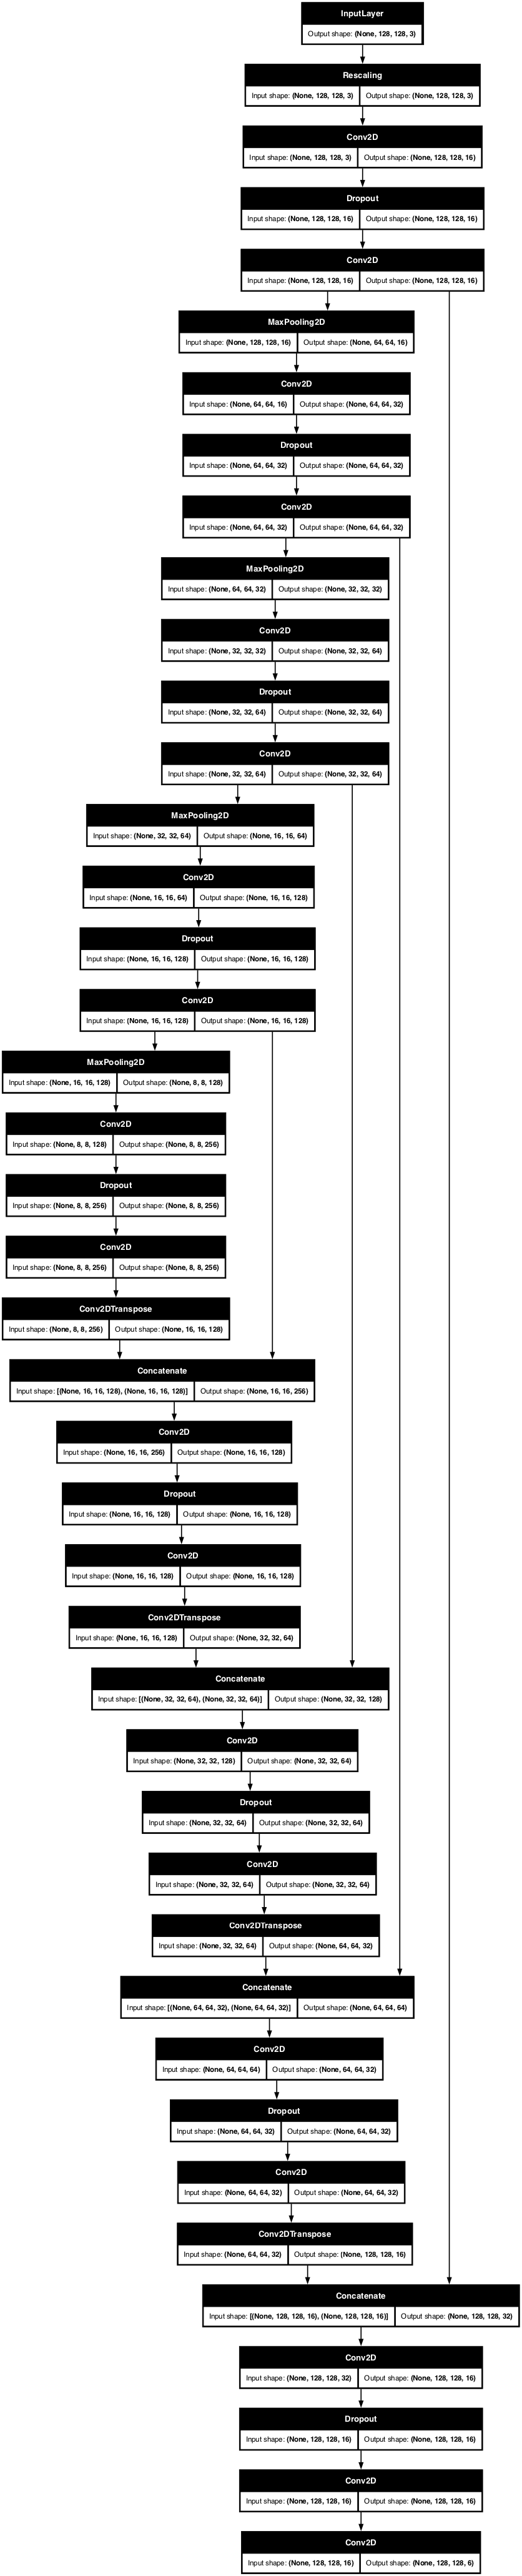

In [63]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, dpi = 60)

We can also use a Python function to create the model. This just allows us to call this if we need to recreate the model, rather than remembering all the steps.

In [64]:
def get_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3, num_classes=3):

    inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = layers.Rescaling(1./255)(inputs)

    # Encoder path: forward step 1
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = layers.Dropout(0.1)(c1)  # Original 0.1
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    # Encoder path: forward step 2
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)  # Original 0.1
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
     
    # Encoder path: forward step 3
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.1)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
     
    # Encoder path: forward step 4
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
    # Latent space
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder path: reverse step 4
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)   
    # Concatenate: reverse step 4 and forward step 4 
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.1)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    # Decoder path: reverse step 3
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)    
    # Concatenate: reverse step 3 and forward step 3
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    # Decoder path: reverse step 2
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    # Concatenate: reverse step 2 and forward step 2
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)  # Original 0.1
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    # Decoder path: reverse step 1
    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    # Concatenate: reverse step 1 and forward step 1
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)  # Original 0.1
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    ## Conncet to target (softmax for num_classes)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = keras.Model(inputs=[inputs], outputs=[outputs])    
    return model

model = get_model(IMG_WIDTH=image_width, IMG_HEIGHT=image_height, IMG_CHANNELS=num_channels, num_classes=num_classes)

### Performance metrics

We'll use two performance metrics (these will be used to assess the predictive skill of the model during validation and testing). We'll use the accuracy - a simple measure of whether a pixel in a mask is correctly predicted or not and the intersection over union (IoU). This latter is the ratio of the overlap between a predicted and observed mask with the intersection or total areas of the two masks. At 1, this indicates a perfect prediction. We'll need to create a function to calculate this, that can then be used by the model:

In [65]:
foreground_iou = keras.metrics.IoU(
    num_classes=num_classes,
    target_class_ids=(0,),
    name="foreground_iou",
    sparse_y_true=True,
    sparse_y_pred=False,
)

Finally, we'll set the optimizer, compile the model and create a callback to save the best performing set of weights during training

In [66]:
optim = keras.optimizers.RMSprop(learning_rate=1e-3)
# optim = keras.optimizers.Adam(learning_rate=0.001)

metrics=['accuracy', foreground_iou]

model.compile(
    optimizer=optim,
    loss="sparse_categorical_crossentropy",
    metrics=metrics,
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "lulc_unet.keras",
        save_best_only=True,
    ),
]

With all that in place, we can train the model. We'll use batchs of 64 images, and run for 25 epochs. 

In [67]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=25,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/25


/opt/homebrew/Caskroom/miniforge/base/envs/tf-5160/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_42']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 678ms/step - accuracy: 0.3862 - foreground_iou: 0.1286 - loss: 1.4025 - val_accuracy: 0.4965 - val_foreground_iou: 0.3238 - val_loss: 1.2158
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 692ms/step - accuracy: 0.4863 - foreground_iou: 0.2790 - loss: 1.1965 - val_accuracy: 0.5676 - val_foreground_iou: 0.3662 - val_loss: 1.1010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 672ms/step - accuracy: 0.5868 - foreground_iou: 0.3837 - loss: 1.0622 - val_accuracy: 0.6579 - val_foreground_iou: 0.4998 - val_loss: 0.9526
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 589ms/step - accuracy: 0.6394 - foreground_iou: 0.4599 - loss: 0.9523 - val_accuracy: 0.6846 - val_foreground_iou: 0.5685 - val_loss: 0.8777
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 584ms/step - accuracy: 0.6652 - foreground_iou: 0.5030 - loss: 0.8841 - val_accuracy: 0.5667 - val_foreground_iou: 0.4049 - val_loss: 1.1204
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.6272 - foreground_iou: 0.4703

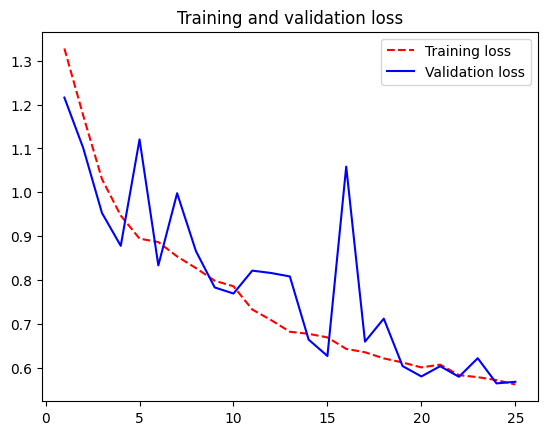

In [68]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

The loss curve is noisy but shows a fairly consistent decline. As it has not yet plateaued, it may be worth increasing the number of epochs to train for longer. 

## Model evaluation

To finish up, we'll take a look at how well the model can segment an image. As we don't have a separate testing set, we'll simply use one of the images from the validation set. The steps here are to 

a) Reload the model weights

In [69]:
from keras.utils import array_to_img

model = keras.models.load_model("lulc_unet.keras")

b) load an image (and mask)

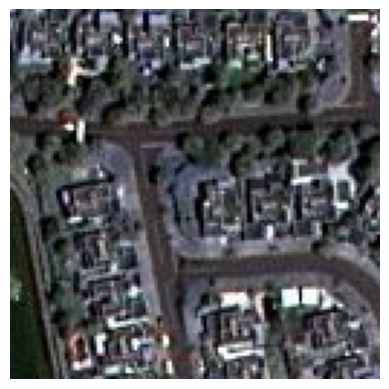

In [70]:
i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

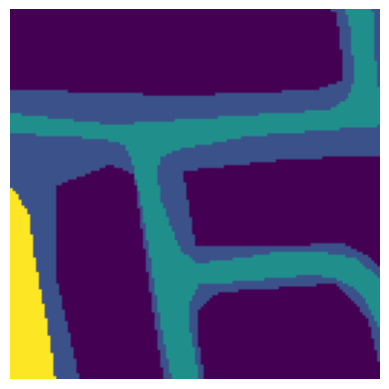

In [71]:
test_mask = val_targets[i]
plt.axis("off")
plt.imshow(array_to_img(test_mask))

c) use the model `predict` function to segment each pixel

In [72]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


d) visualize the prediction (the class with the highest probability)

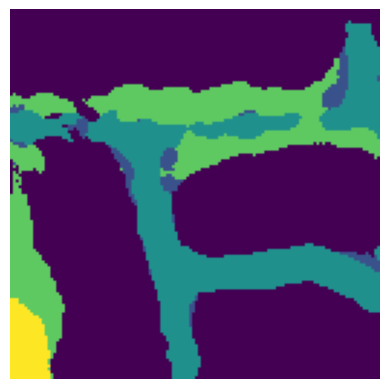

In [73]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    # mask *= 127
    # mask += 1
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

The resulting segmentation is far from perfect here, but given the size of the input data and the relatively short training period, it is already starting to capture the spatial patterns in this image. The next steps are likely to be:

- Add the full set of images
- Train for longer (100 epochs)
- Add data augmentation

# Appendix

The code below was used to convert the original image into the smaller 128x128 tiles, and I've appended it here in case it is useful. It's commented out, so that it doesn't run in the current notebook. This needs the Python library **patchify** to split the images up (`pip install patchify`). 

This assumes that the original (large) images are in the folder `./datafiles/images2/` and the tiles will be written to `./datafiles/images3`

Get list of image and mask files

In [74]:
# base_dir = './datafiles/images2/'
# image_dir = base_dir + 'images/'
# mask_dir = base_dir + 'masks/'
# image_names = sorted(os.listdir(image_dir))
# mask_names = [sub.replace('jpg', 'png') for sub in image_names]

Next, we define the size of each sub-image, as well as the step used to create the patches. We'll use a step equal to the patch size, which splits the image into non-overlapping regions. Reducing this will create a larger set of images that overlap, and may be a further way to increase the input data.

In [75]:
# patch_size = 64
# step_size = 64

Crop images to fit tiles

In [76]:
# SIZE_X = (image.shape[1]//patch_size)*patch_size 
# SIZE_Y = (image.shape[0]//patch_size)*patch_size 
# image = Image.fromarray(image)
# image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
# image.height

Now loop over the original image files, use `patchify` to split into tiles, and write these out

In [77]:
# image_dataset = []
# for image_name in image_names:
#   image_file = image_dir + image_name
#   image = cv2.imread(image_file,1) 

#   out_file_root = os.path.splitext(image_name)[0]
#   SIZE_X = (image.shape[1]//patch_size)*patch_size 
#   SIZE_Y = (image.shape[0]//patch_size)*patch_size 
#   image = Image.fromarray(image)
#   image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
#   image = np.array(image) 
#   patches_img = patchify(image, (patch_size, patch_size, 3), step=step_size)  

#   img_id = 0
#   for i in range(patches_img.shape[0]):
#     for j in range(patches_img.shape[1]):
#       single_patch_img = patches_img[i,j,:,:]
#       single_patch_img = single_patch_img[0]
#       image_dataset.append(single_patch_img) 
#       tmp_id = str(img_id)
#       tmp_id = tmp_id.zfill(3) 
#       patch_filename = out_image_dir + out_file_root + '_' + tmp_id + '.jpg'
#       img_id += 1
#       # Save the patch as an image
#       cv2.imwrite(patch_filename, single_patch_img)

And do the same for the masks. Note that here we also convert the original mask image (RGB) to a single channel with an integer representation

In [78]:
# mask_dataset = []
# for mask_name in mask_names:
#   mask_file = mask_dir + mask_name
#   mask = cv2.imread(mask_file,1) 
#   out_file_root = os.path.splitext(mask_name)[0]
  
#   mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#   SIZE_X = (mask.shape[1]//patch_size)*patch_size 
#   SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
#   mask = Image.fromarray(mask)
#   mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  

#   mask = np.array(mask)             
        
#   patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  
          
#   img_id = 0
#   for i in range(patches_mask.shape[0]):
#     for j in range(patches_mask.shape[1]):
#       single_patch_mask = patches_mask[i,j,:,:]    
#       single_patch_mask = single_patch_mask[0]                         
#       mask_dataset.append(single_patch_mask) 
#       label = rgb_to_2D_label(single_patch_mask)

#       tmp_id = str(img_id)
#       tmp_id = tmp_id.zfill(3) 
#       patch_filename = out_mask_dir + out_file_root + '_' + tmp_id + '.png'

#       # Save the patch as an image
#       cv2.imwrite(patch_filename, label)
      
#       img_id += 1